# Question 1

## Stochastic process and Gaussian process

A stochastic process is a collection of random variables indexed by time or other continuous parameter. It is used to model systems that evolve with  randomness. For example, a stochastic process might model the unpredictable fluctuations of stock prices or the random diffusion of particles. The key idea is that at each point in the index set (e.g., time), there is a random variable, and the collection of these random variables characterizes the overall behavior.


A Gaussian process is a specific type of stochastic process where every finite collection of random variables follows a multivariate Gaussian distribution. GPs are specified by two functions:

- Mean Function: Gives the expected value of the process at any point.
- Kernel Function: Describes how points in the process co-vary (i.e., how similar or correlated they are based on their distance or other properties).

## Variational Inference and ELBO

Variational inference is an approximate inference technique used to compute posterior distributions, which are often intractable. Instead of sampling directly from the true posterior, VI uses a simpler, parameterized family of distributions (called the variational family) and then finds the member of this family that is closest to the true posterior.


ELBO is the tractable lower bound to the lagarithm of the marginal likelihood of the observed data. For example, if $q(\theta)$ is the variational approximation to the true posterior $p(\theta|X)$, the ELBO is defined as:

$$\begin{aligned}
\text{ELBO}(q) = \mathbb{E}[\log p(X,\theta)]-\mathbb{E}[\log q(\theta)]
\end{aligned}$$
This can be interpreted in two components:
The first term is the expected log joint probability under variational distribution and the second term is the entropy of the variational distribution.
Maximizing ELBO is equal to minimizing the Kullback-Leibler (KL) divergence between $q(\theta)$ and true posterior $p(\theta|X)$. By doing so, we obtain the best approximation within the chosen variational family.



# Question 2

In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns

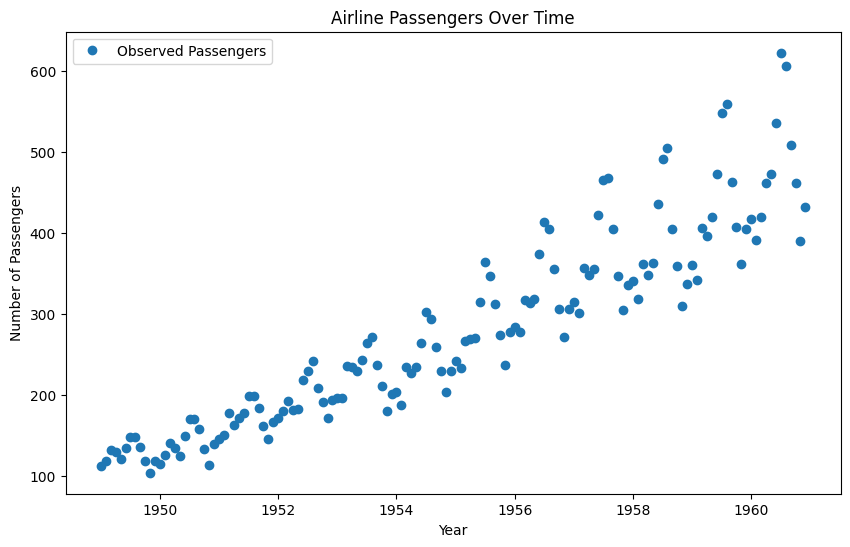

In [2]:
flights = sns.load_dataset("flights")

# Convert month names to numeric values.
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_to_num = {month: i for i, month in enumerate(months, start=1)}
flights["month_num"] = flights["month"].map(month_to_num).astype(int)

# Create a continuous time variable: year + (month-1)/12.
flights["time"] = flights["year"] + (flights["month_num"] - 1) / 12.0

# Extract inputs and outputs.
# X is the time (as a column vector) and y the passenger counts.
X = flights["time"].values[:, None]
y = flights["passengers"].values

# Visualize the raw data.
plt.figure(figsize=(10, 6))
plt.plot(X, y, "o", label="Observed Passengers")
plt.xlabel("Year")
plt.ylabel("Number of Passengers")
plt.title("Airline Passengers Over Time")
plt.legend()
plt.show()


In [7]:
with pm.Model() as model:
    # Long-term trend GP component
    ls_trend = pm.Gamma("ls_trend", alpha=2, beta=1)
    eta_trend = pm.HalfNormal("eta_trend", sigma=10)
    cov_trend = eta_trend**2 * pm.gp.cov.ExpQuad(1, ls_trend)
    gp_trend = pm.gp.Marginal(cov_func=cov_trend)

    # Seasonal (periodic) GP component
    ls_season = pm.Gamma("ls_season", alpha=2, beta=1)
    eta_season = pm.HalfNormal("eta_season", sigma=10)

    cov_season = eta_season**2 * pm.gp.cov.Periodic(input_dim=1, period=1.0, ls=ls_season)
    gp_season = pm.gp.Marginal(cov_func=cov_season)

    # The additive GP: total effect is the sum of trend and seasonal components.
    gp_total = gp_trend + gp_season

    # Likelihood
    sigma = pm.HalfNormal("sigma", sigma=10)

    # Specify the marginal likelihood over the observed data.
    y_obs = gp_total.marginal_likelihood("y_obs", X=X, y=y, sigma=sigma)

    # Sample from the posterior.
    trace = pm.sample(1000)

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [8]:
 with model:
    # Create a dense grid of time points for predictions.
    X_new = np.linspace(X.min(), X.max(), 300)[:, None]
    f_pred = gp_total.conditional("f_pred", X_new, jitter=1e-3)
    # Compute the conditional GP at the new inputs.
    pred_samples = pm.sample_posterior_predictive(trace, var_names=["f_pred"])


Output()

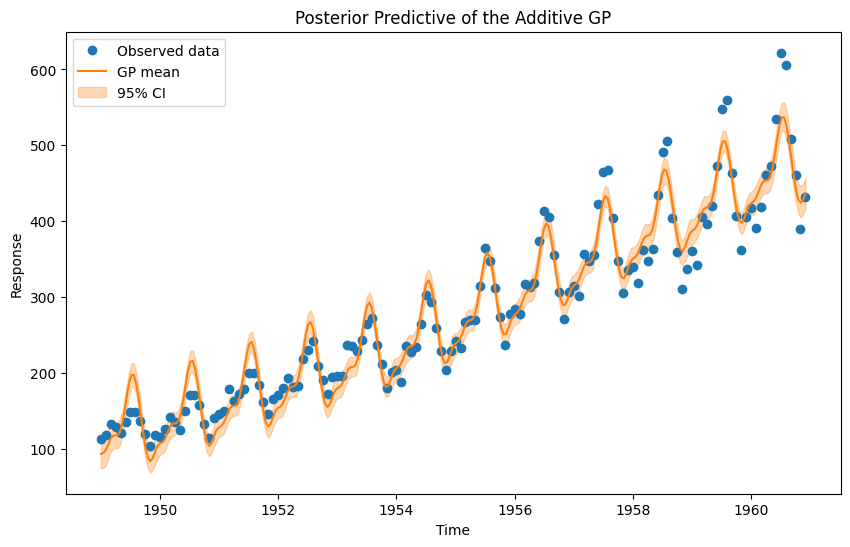

In [12]:
# Extract the predictive samples from the InferenceData.
f_pred_values = pred_samples.posterior_predictive["f_pred"].values
# f_pred_values has shape (chains, draws, n_points). Combine chains and draws:
f_pred_samples = f_pred_values.reshape(-1, f_pred_values.shape[-1])

# Compute the posterior predictive mean and 95% credible intervals.
mean_pred = np.mean(f_pred_samples, axis=0)
lower_bound = np.percentile(f_pred_samples, 2.5, axis=0)
upper_bound = np.percentile(f_pred_samples, 97.5, axis=0)

# Visualize the results.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(X, y, "o", label="Observed data")
plt.plot(X_new, mean_pred, "C1", label="GP mean")
plt.fill_between(X_new.flatten(), lower_bound, upper_bound, color="C1", alpha=0.3, label="95% CI")
plt.xlabel("Time")
plt.ylabel("Response")
plt.title("Posterior Predictive of the Additive GP")
plt.legend()
plt.show()


In this example, we combine two Gaussian process components:
- Trend Component (ExpQuad Kernel):
Models a smooth, long-term increase in passenger numbers over time.
- Seasonal Component (Periodic Kernel):
Models the repeating (yearly) seasonality in passenger numbers.

By adding these two GP components together, we create an additive GP model that can capture both the global trend and the regular seasonal pattern in the data.

The final figure illustrates:
A smooth increasing trend over the years, captured by the ExpQuad kernel component and a seasonal fluctuation around that trend, captured by the Periodic kernel.
Uncertainty bands (the shaded region) that widen slightly in areas where data is more sparse or where the model is less certain about the function's behavior.

This example demonstrates how Gaussian processes can be used to model complex time series data by decomposing it into interpretable parts (trend + seasonality), while providing posterior uncertainty estimates that are crucial for many real-world forecasting or analysis tasks.


# Question 3

In [14]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set float type and random seed
floatX = pytensor.config.floatX
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# ----------------------------
# 1. Load and Preprocess the Titanic Dataset
# ----------------------------
# Load Titanic data from seaborn.
titanic = sns.load_dataset("titanic")

# We use 'age' and 'fare' as features and 'survived' as target.
# Drop rows with missing values.
titanic = titanic.dropna(subset=["age", "fare", "survived"])

# Extract features and target.
X = titanic[["age", "fare"]].values.astype(floatX)
Y = titanic["survived"].values.astype(floatX)

# Standardize features.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets.
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.5, random_state=RANDOM_SEED
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (357, 2)
Test set shape: (357, 2)


In [15]:

def construct_nn(batch_size=50):
    n_hidden = 5
    init_1 = rng.standard_normal(size=(X_train.shape[1], n_hidden)).astype(floatX)
    init_2 = rng.standard_normal(size=(n_hidden, n_hidden)).astype(floatX)
    init_out = rng.standard_normal(size=n_hidden).astype(floatX)

    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "train_cols": np.arange(X_train.shape[1]),
        "obs_id": np.arange(X_train.shape[0]),
    }

    with pm.Model(coords=coords) as neural_network:
        # Define data nodes.
        X_data = pm.Data("X_data", X_train, dims=("obs_id", "train_cols"))
        Y_data = pm.Data("Y_data", Y_train, dims="obs_id")

        # minibatches for stochastic optimization.
        ann_input, ann_output = pm.Minibatch(X_data, Y_data, batch_size=batch_size)

        # Weights from input to first hidden layer.
        weights_in_1 = pm.Normal(
            "w_in_1", mu=0, sigma=1, initval=init_1, dims=("train_cols", "hidden_layer_1")
        )

        # Weights from first to second hidden layer.
        weights_1_2 = pm.Normal(
            "w_1_2", mu=0, sigma=1, initval=init_2, dims=("hidden_layer_1", "hidden_layer_2")
        )

        # Weights from second hidden layer to output.
        weights_2_out = pm.Normal(
            "w_2_out", mu=0, sigma=1, initval=init_out, dims="hidden_layer_2"
        )

        # Construct the neural network: two hidden layers with tanh activations.
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        # Bernoulli likelihood for binary classification.
        out = pm.Bernoulli(
            "out",
            p=act_out,
            observed=ann_output,
            total_size=X_train.shape[0],
        )
    return neural_network

# Build the neural network model.
neural_network = construct_nn()




def sample_posterior_predictive(X_test, Y_test, trace, n_hidden=5):
    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "train_cols": np.arange(X_test.shape[1]),
        "obs_id": np.arange(X_test.shape[0]),
    }
    with pm.Model(coords=coords) as model_ppc:
        # Use full test set as input.
        ann_input = X_test
        ann_output = Y_test

        # Define non-informative Flat priors for weights.
        weights_in_1 = pm.Flat("w_in_1", dims=("train_cols", "hidden_layer_1"))
        weights_1_2 = pm.Flat("w_1_2", dims=("hidden_layer_1", "hidden_layer_2"))
        weights_2_out = pm.Flat("w_2_out", dims="hidden_layer_2")

        # Reconstruct the neural network.
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        out = pm.Bernoulli("out", p=act_out, observed=ann_output)
        return pm.sample_posterior_predictive(trace, model=model_ppc)


Output()

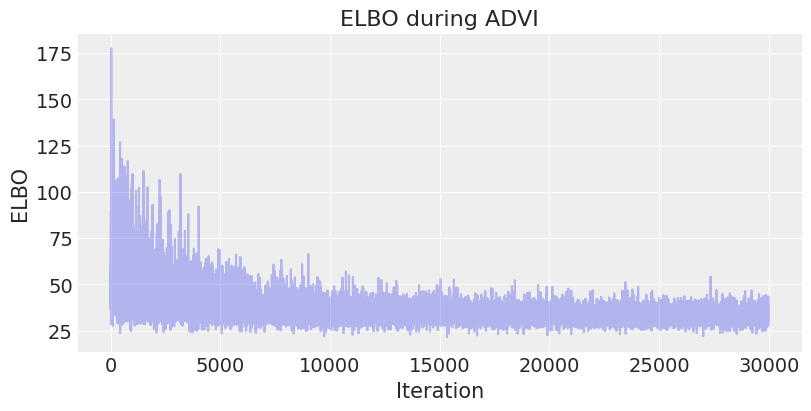

In [16]:
with neural_network:
    # Fit the model using ADVI
    approx = pm.fit(n=30000, method="advi", progressbar=True)

    # Plot the ELBO (objective function) to monitor convergence.
    plt.figure(figsize=(8, 4))
    plt.plot(approx.hist, alpha=0.3)
    plt.ylabel("ELBO")
    plt.xlabel("Iteration")
    plt.title("ELBO during ADVI")
    plt.show()

# Draw samples from the variational posterior.
trace = approx.sample(draws=5000)



Output()

Accuracy on the test set = 68.07%


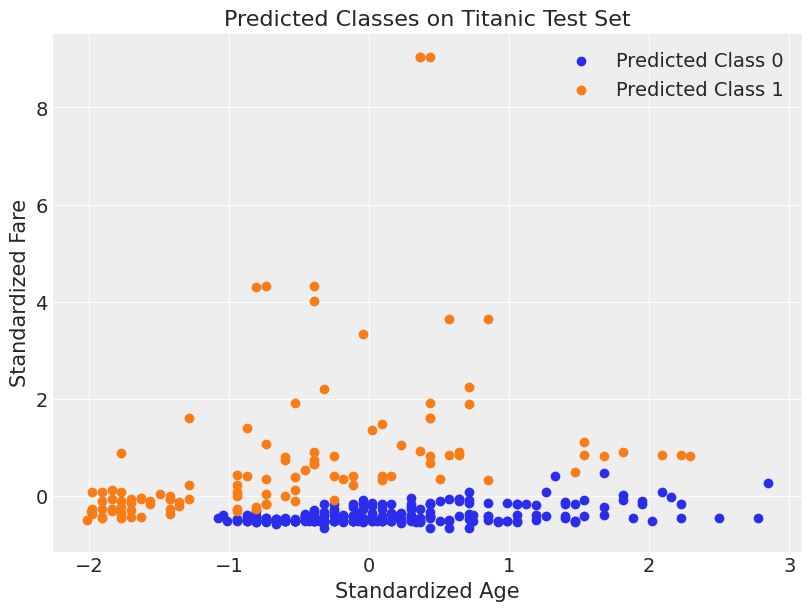

In [17]:
ppc = sample_posterior_predictive(X_test, Y_test, trace, n_hidden=5)

pred_probs = ppc.posterior_predictive["out"].mean(("chain", "draw"))
pred_classes = (pred_probs > 0.5).astype(int)

# Compute test set accuracy.
accuracy = (Y_test == pred_classes.values).mean() * 100
print(f"Accuracy on the test set = {accuracy:.2f}%")

plt.figure(figsize=(8, 6))
plt.scatter(
    X_test[pred_classes.values.flatten() == 0, 0],
    X_test[pred_classes.values.flatten() == 0, 1],
    color="C0",
    label="Predicted Class 0",
)
plt.scatter(
    X_test[pred_classes.values.flatten() == 1, 0],
    X_test[pred_classes.values.flatten() == 1, 1],
    color="C1",
    label="Predicted Class 1",
)
plt.xlabel("Standardized Age")
plt.ylabel("Standardized Fare")
plt.title("Predicted Classes on Titanic Test Set")
plt.legend()
plt.show()


In this example, I used ADVI (Automatic Differentiation Variational Inference) to approximate and convert the posterior sampling problem into an optimization problem.

ELBO Plot shows how the ELBO evolves during training. A decreasing ELBO indicates the variational approximation is improving.

Although the performance of this model is not great, this dataset is constrained with only 300 data points with relatively simple neural network.  
